#Building ML pipeline using XGboost and LightGBM for predicting energy requirement

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

# Model
from xgboost import XGBRegressor

In [37]:
pip install lightgbm

#Loading the dataset and data manipulation

In [20]:
#Loading Excel file
file_path = "Worksheet in Predicting Energy Consumption.xlsm"
df = pd.read_excel(file_path)

#Checking first few rows
print(df.head())

       Start time UTC        End time UTC  Electricity consumption (MWh)
0 2015-12-31 21:00:00 2015-12-31 22:00:00                          10800
1 2015-12-31 22:00:00 2015-12-31 23:00:00                          10431
2 2015-12-31 23:00:00 2016-01-01 00:00:00                          10005
3 2016-01-01 00:00:00 2016-01-01 01:00:00                           9722
4 2016-01-01 01:00:00 2016-01-01 02:00:00                           9599


#Rename Columns

In [21]:
df.rename(columns={
    "Start time UTC": "start_time",
    "End time UTC": "end_time",
    "Electricity consumption (MWh)": "consumption"
}, inplace=True)

#Convert to Datetime & Set Index

In [22]:
#Converting to datetime
df["start_time"] = pd.to_datetime(df["start_time"])

#Sorting values
df = df.sort_values("start_time")

#Set as index
df.set_index("start_time", inplace=True)

#Drop end_time
df.drop(columns=["end_time"], inplace=True)

#Missing values

In [49]:
#Checking missing values
print(df.isnull().sum())



consumption        0
hour               0
month              0
lag_1              0
lag_24             0
lag_168            0
rolling_mean_24    0
rolling_std_24     0
dtype: int64


#Feature Engineering

Creating Time-Based Features

In [24]:
# Basic time features
df["hour"] = df.index.hour
df["month"] = df.index.month



Creating Lag Features

In [25]:
#1 hour lag
df["lag_1"] = df["consumption"].shift(1)

#24 hour lag same hour previous day
df["lag_24"] = df["consumption"].shift(24)

#168 hour lag same hour previous week
df["lag_168"] = df["consumption"].shift(168)

Rolling Features


In [26]:
#Rolling mean
df["rolling_mean_24"] = df["consumption"].rolling(window=24).mean()

#Rolling std
df["rolling_std_24"] = df["consumption"].rolling(window=24).std()

In [27]:
#Droping NaN from Lag Creation
df.dropna(inplace=True)

In [28]:
#Target variable
X = df.drop("consumption", axis=1)
y = df["consumption"]

In [29]:
#Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

#ML Pipeline - XGboost

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor

pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("model", XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    ))
])

#Train and Evaluate

In [46]:
mae_scores = []
rmse_scores = []
r2_scores = []

for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)


xgb_results = {
    "MAE": np.mean(mae_scores),
    "RMSE": np.mean(rmse_scores),
    "R2": np.mean(r2_scores)
}


print("XGBoost Results")
print("Average MAE:", xgb_results["MAE"])
print("Average RMSE:", xgb_results["RMSE"])
print("Average R2:", xgb_results["R2"])

XGBoost Results
Average MAE: 82.85401153564453
Average RMSE: 117.23783415104313
Average R2: 0.9935886263847351


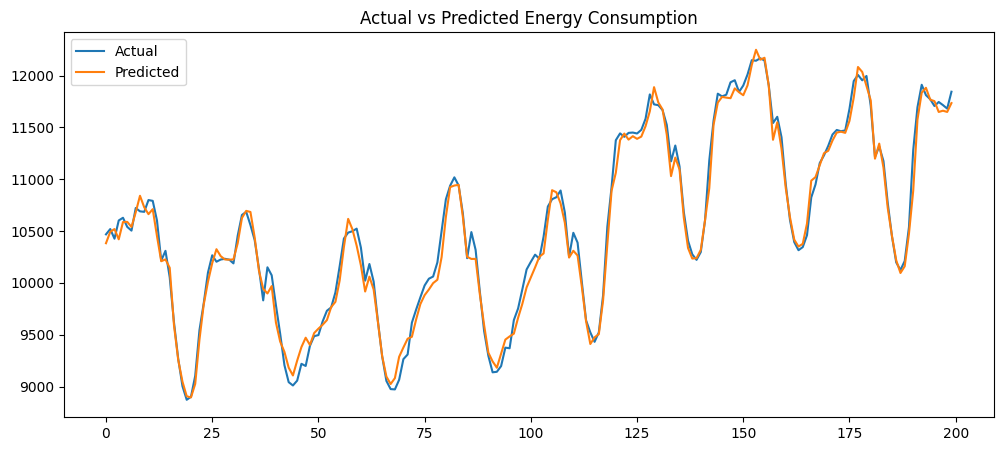

In [32]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual")
plt.plot(y_pred[:200], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Energy Consumption")
plt.show()

#ML pipeline using LightGBM model

In [39]:
lgb_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    random_state=42
)

In [61]:
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create LightGBM pipeline
lgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LGBMRegressor(
        n_estimators=300,
        learning_rate=0.08,
        num_leaves=31,
        random_state=42
    ))
])

mae_scores = []
rmse_scores = []
r2_scores = []

for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lgb_pipeline.fit(X_train, y_train)
    y_pred = lgb_pipeline.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_scores.append(r2_score(y_test, y_pred))

lgb_results = {
    "MAE": np.mean(mae_scores),
    "RMSE": np.mean(rmse_scores),
    "R2": np.mean(r2_scores)
}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1313
[LightGBM] [Info] Number of data points in the train set: 8803, number of used features: 7
[LightGBM] [Info] Start training from score 9548.608770


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1313
[LightGBM] [Info] Number of data points in the train set: 17602, number of used features: 7
[LightGBM] [Info] Start training from score 9526.310703


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1313
[LightGBM] [Info] Number of data points in the train set: 26401, number of used features: 7
[LightGBM] [Info] Start training from score 9625.616908


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1313
[LightGBM] [Info] Number of data points in the train set: 35200, number of used features: 7
[LightGBM] [Info] Start training from score 9573.168068


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1313
[LightGBM] [Info] Number of data points in the train set: 43999, number of used features: 7
[LightGBM] [Info] Start training from score 9441.606673


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


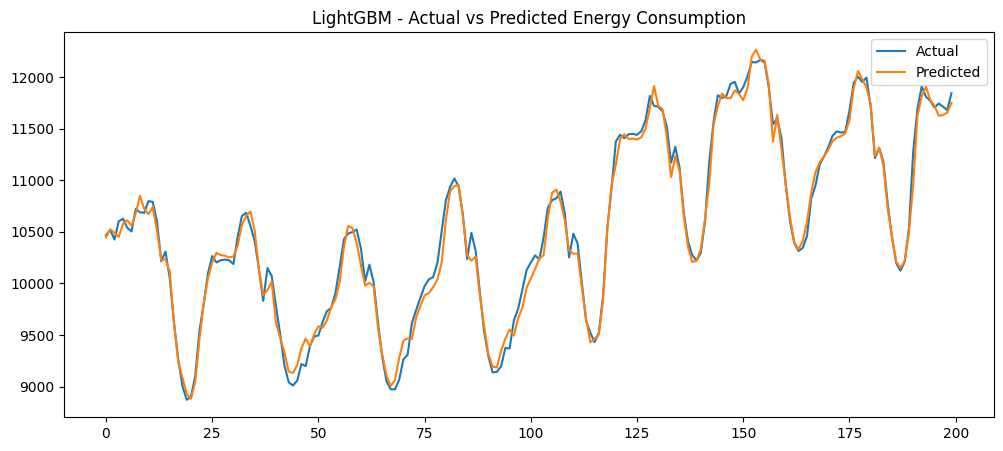

In [62]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual")
plt.plot(y_pred[:200], label="Predicted")
plt.legend()
plt.title("LightGBM - Actual vs Predicted Energy Consumption")
plt.show()

#XGboost and LightGBM comparison

In [63]:
print("\nModel Comparison")


print("XGBoost:")
print("Average MAE :", xgb_results["MAE"])
print("Average RMSE:", xgb_results["RMSE"])
print("Average R2  :", xgb_results["R2"])

print("\nLightGBM:")
print("Average MAE :", lgb_results["MAE"])
print("Average RMSE:", lgb_results["RMSE"])
print("Average R2  :", lgb_results["R2"])


Model Comparison
XGBoost:
Average MAE : 82.85401153564453
Average RMSE: 117.23783415104313
Average R2  : 0.9935886263847351

LightGBM:
Average MAE : 79.55340206010037
Average RMSE: 113.10836914648033
Average R2  : 0.9939842900378956
